In [4]:
import sys
sys.path.append(r'C:\Study\SpeechAcquisitionModel')
import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch
import os
from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.speech_classification.pytorch_lstm_ensmble_s2s import LstmNet, LstmNetEnsemble
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [141]:

phonemes = ['a', 'i', 'o', 'u']
phoneme_transitions = ['ai', 'au', 'ao',
                        'ia', 'iu', 'io',
                        'ua', 'ui', 'uo',
                        'oa', 'oi', 'ou']
total_classes =  ['sil', 'none'] + phonemes + phoneme_transitions

le = preprocessing.LabelEncoder()
le.fit(total_classes)
model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(total_classes),
    'hidden_reccurent_cells_count': 128,
    'winlen': 0.04,
    'winstep': 0.04,
    'num_nets': 10
}

preproc = AudioPreprocessorFbank(nfilt=model_settings['dct_coefficient_count'], winlen=model_settings['winlen'], winstep=model_settings['winstep'])

data_dir = r'C:\Study\Speech_command_classification\speech_dataset'
dataset_fname = r'C:\Study\SpeechAcquisitionModel\data\raw\Simple_transitions_s2s\07_04_2019_01_11_PM_31\07_04_2019_01_11_PM_31.pd'
df = pd.read_pickle(dataset_fname)

processed_audio = []
labels_int = []
print("preprocessing audio...")

for i in range(df.shape[0]):
    print(f"\r{i}", end="")
    sr = 22050
    sample = df.iloc[i]
    audio = sample['audio'].flatten()
    audio_proc = preproc(audio, sr)
    processed_audio.append(audio_proc)
    labels_int.append(le.transform(sample['labels']))

processed_audio = np.array(processed_audio)
labels_int = np.array(labels_int)



# load best model
net_fname = r"C:/Study/SpeechAcquisitionModel/models/speech_classification/simple_lstm_07_05_2019_09_58_AM_acc_0.8409.pt"

net = torch.load(net_fname)
net.eval()
print("loaded")


# data = torch.from_numpy(data).float()
# labels = torch.from_numpy(labels).long()


# pred, hidden, _, _ = net(data, seq_lengths)
# pred = torch.stack(pred).mean(dim=0)
# test_loss = torch.nn.CrossEntropyLoss()(pred, labels)

# print(test_loss.detach().numpy())

preprocessing audio...
4799loaded


In [142]:
def predict_show(label, processed_audio, labels_int, net, le):
#         ax1 = plt.subplot(1, n_samples_per_class, i+1)
    # plot mfccs
    plt.figure(figsize=(7,3))
    plt.imshow(processed_audio[:].T[:, 2:] ,aspect='auto')
    plt.colorbar()
    plt.title("Mel-Fbank " + label)
    labels_str = le.inverse_transform(labels_int[2:])
#     print(labels_str)
#     print(labels_int[idx][2:])
#     print(le.classes_)
    num_ticks = processed_audio.shape[0]-2
    ticks_x = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))
    plt.show()
    
    # predict
    data = torch.from_numpy(processed_audio[2:,:]).float().unsqueeze(dim=0)
    pred, hidden, out, full_pred_0 = net(data, np.array([data.shape[1]]))
    full_pred_0 = torch.stack(full_pred_0)
    full_pred = torch.nn.Softmax(dim=-1)(full_pred_0)
    full_pred_std = full_pred.std(dim=0).detach().cpu().numpy().squeeze()
#         print(full_pred.shape)
#         print(full_pred_std.shape)
    full_pred = full_pred.mean(dim=0).squeeze()
    log_full_pred = torch.nn.LogSoftmax(dim=-1)(full_pred_0)
    log_full_pred = log_full_pred.mean(dim=0).squeeze()
    entropy = -1 * (full_pred * log_full_pred).sum(dim=-1)
    loss = torch.nn.CrossEntropyLoss(reduction='none')(full_pred_0.mean(dim=0).squeeze(),
                                                       torch.from_numpy(labels_int[2:].flatten()).long())
    cost = loss * torch.exp(-entropy) + 0.1 * entropy
#     print(full_pred)
#     print(loss)
#     print(loss.shape)

    # plot predictions 
    plt.figure(figsize=(7,3))
    plt.imshow(full_pred.detach().numpy().T, aspect='auto')
    ticks = plt.yticks(np.arange(0, len(total_classes)), le.classes_)
    ticks = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))
    plt.colorbar()
    plt.title('mean prediction '+ label)
    
    # plot predictions std
    plt.figure(figsize=(7,3))
    plt.imshow(full_pred_std.T, aspect='auto')
    ticks = plt.yticks(np.arange(0, len(total_classes)), le.classes_)
    ticks = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))
    plt.colorbar()
    plt.title('std prediction '+ label)
    
    # plot prediction entropy
    plt.figure(figsize=(7,3))
    plt.plot(entropy.detach().cpu().numpy())
#     print(entropy.shape)
#     plt.yticks(np.arange(0, len(total_classes)), le.classes_)
    plt.title('entropy '+ label)
    ticks = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))
    
     # plot prediction loss
    plt.figure(figsize=(7,3))
    plt.plot(loss.detach().cpu().numpy())
#     print(entropy.shape)
#     plt.yticks(np.arange(0, len(total_classes)), le.classes_)
    plt.title('loss '+ label)
    ticks = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))
    
     # plot prediction cost
    plt.figure(figsize=(7,3))
    plt.plot(cost.detach().cpu().numpy())
#     print(entropy.shape)
#     plt.yticks(np.arange(0, len(total_classes)), le.classes_)
    plt.title('cost '+ label)
    ticks = plt.xticks(np.arange(0, num_ticks), le.inverse_transform(labels_int[2:]))



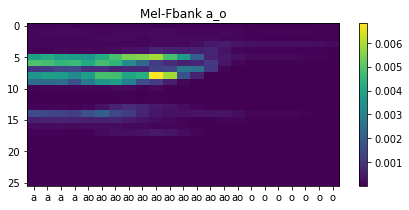

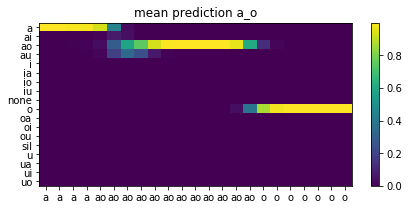

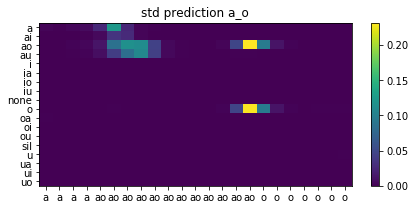

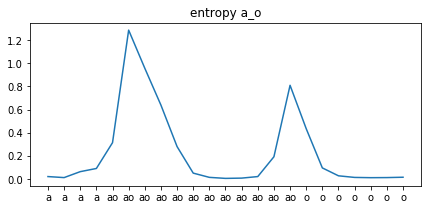

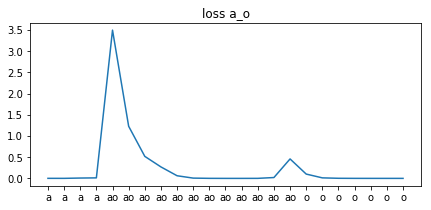

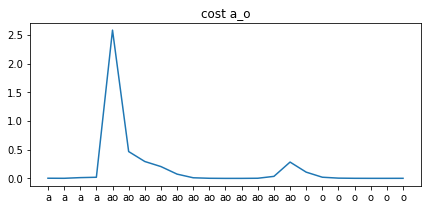

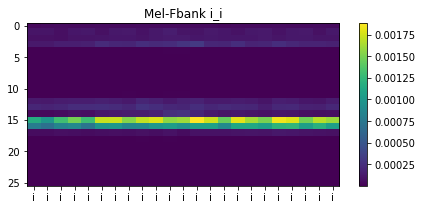

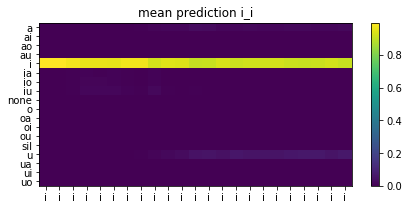

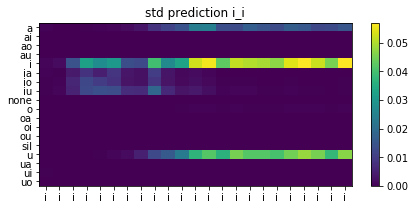

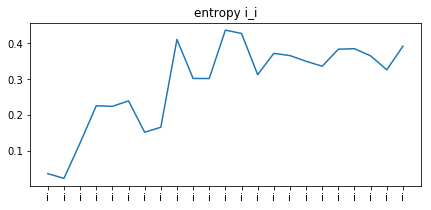

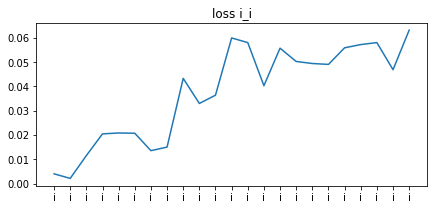

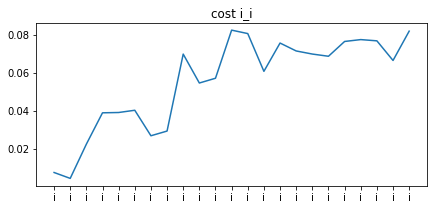

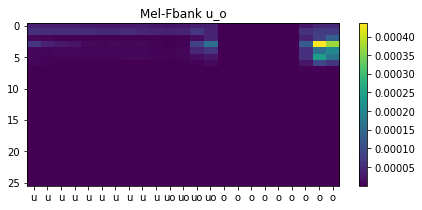

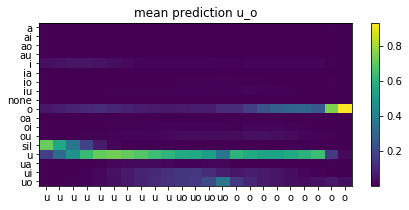

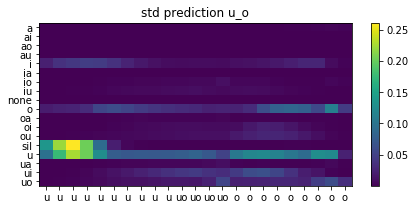

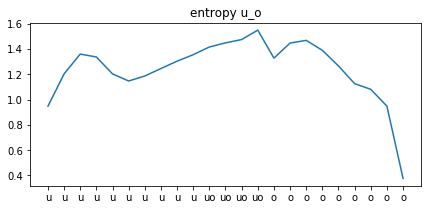

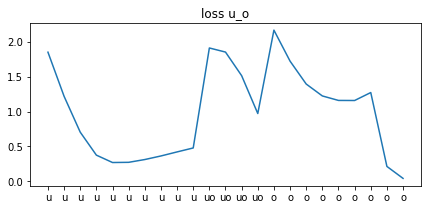

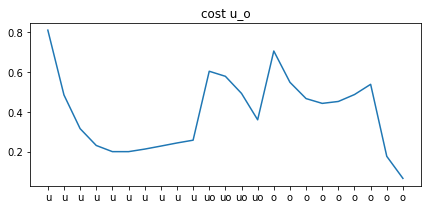

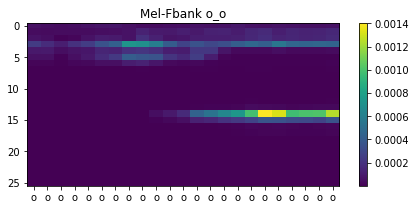

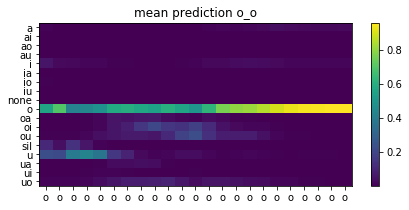

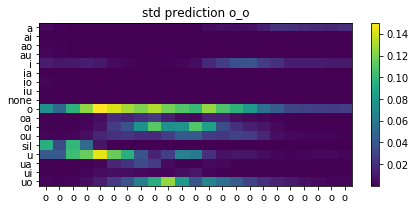

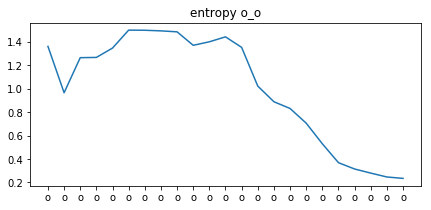

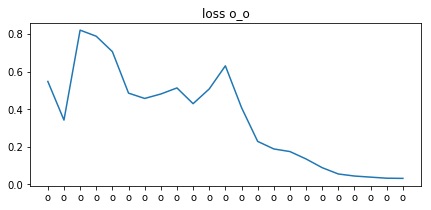

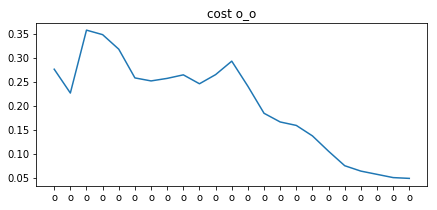

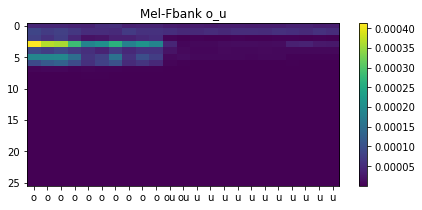

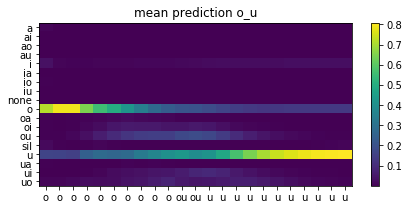

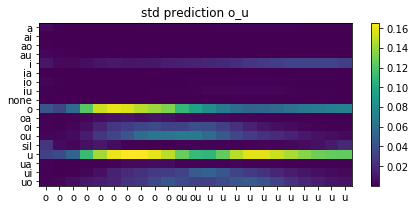

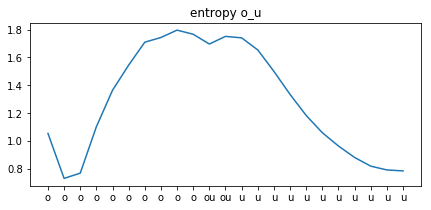

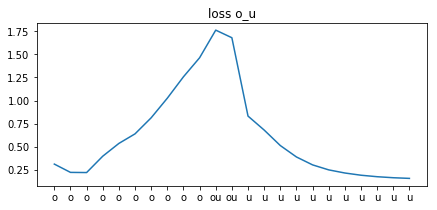

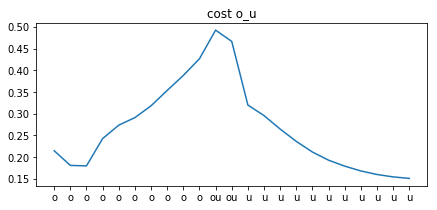

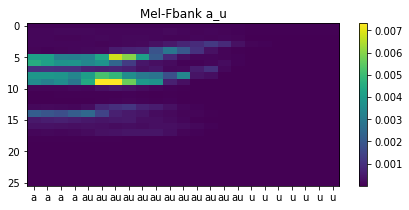

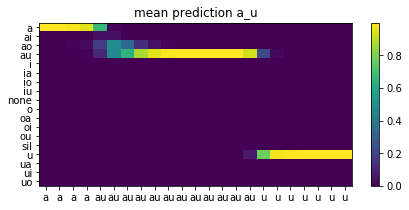

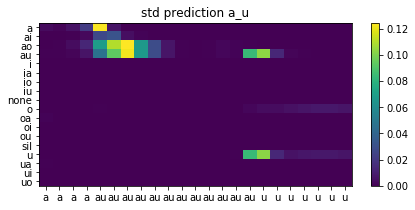

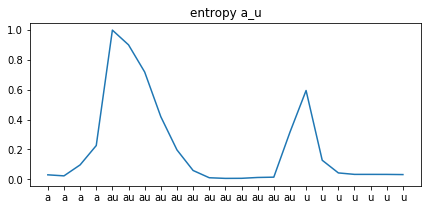

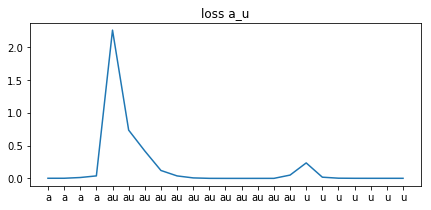

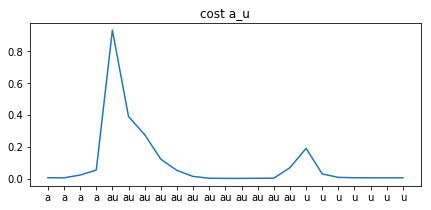

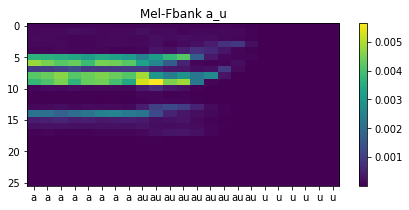

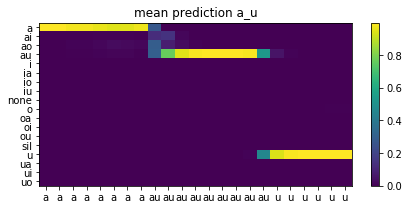

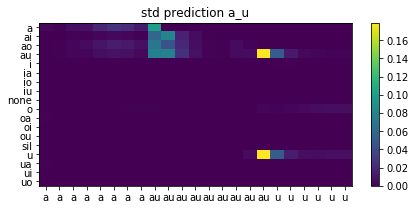

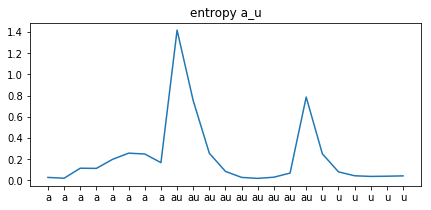

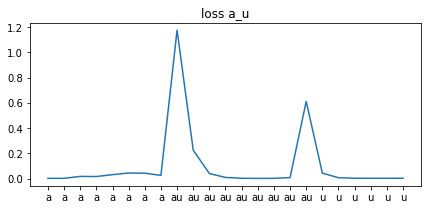

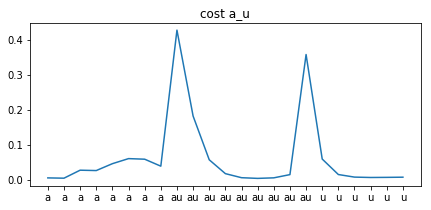

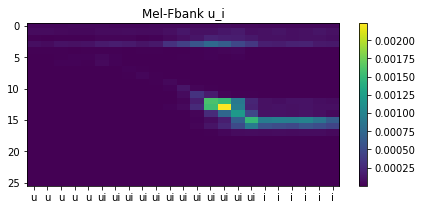

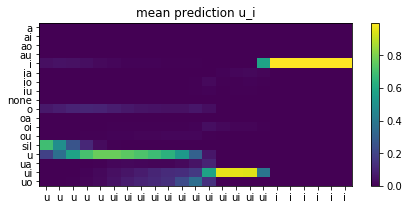

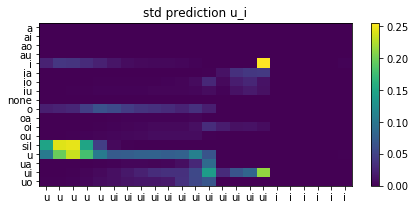

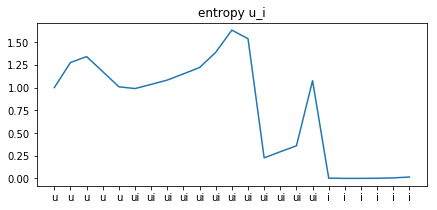

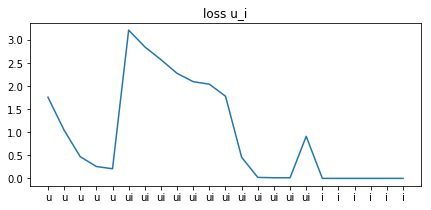

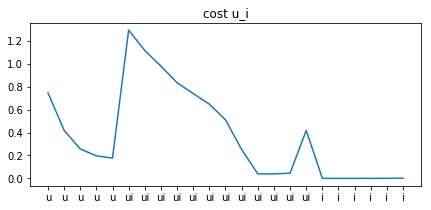

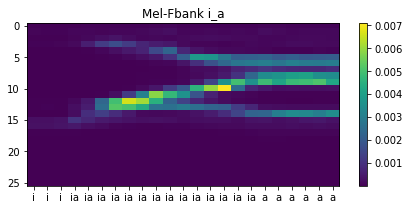

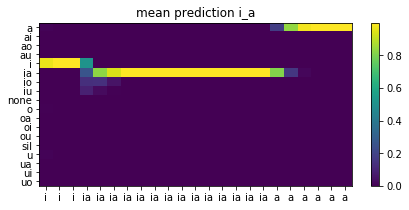

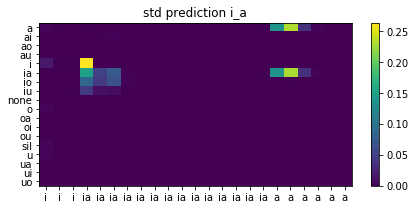

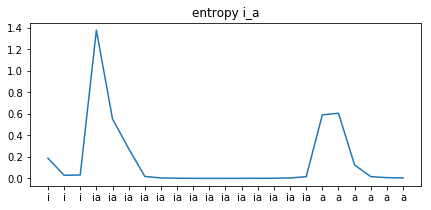

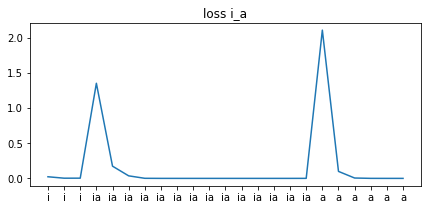

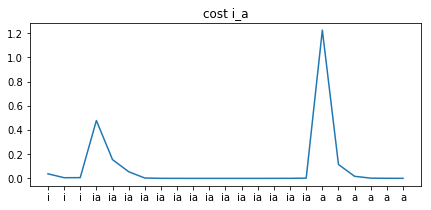

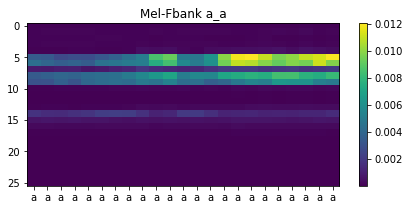

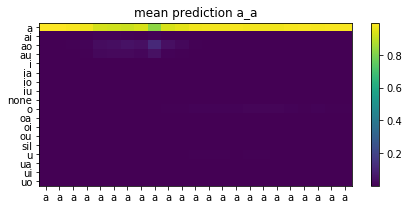

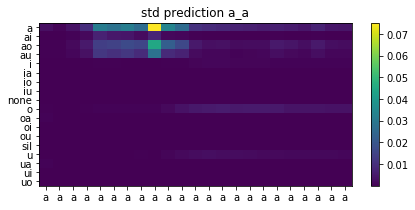

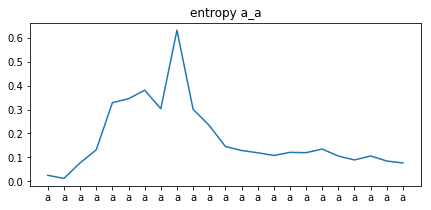

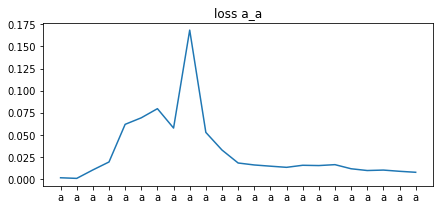

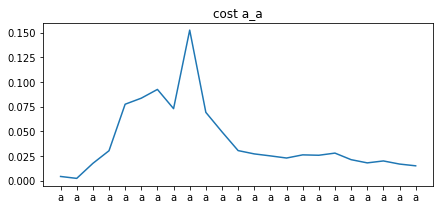

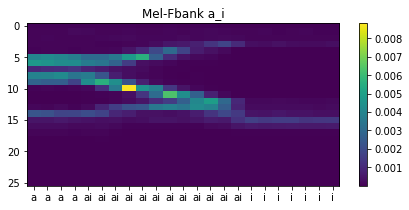

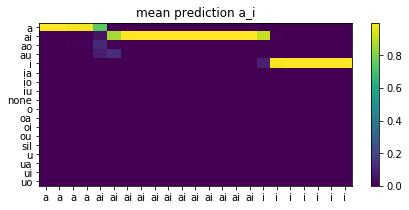

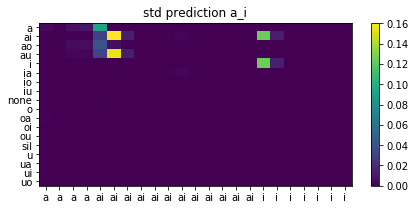

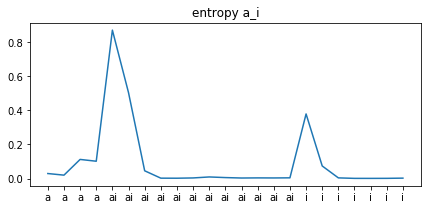

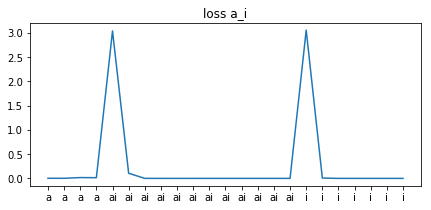

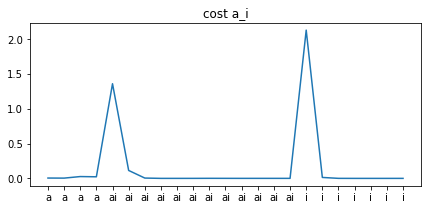

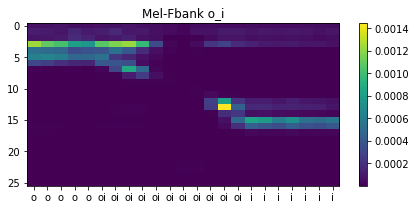

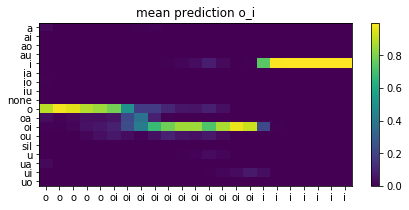

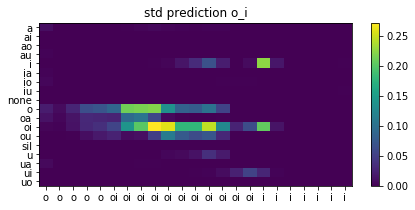

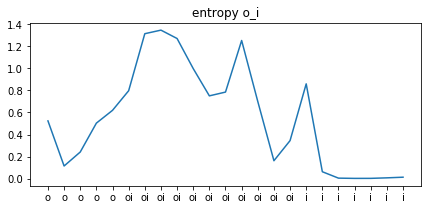

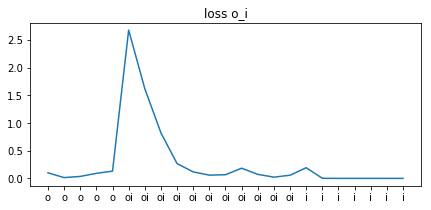

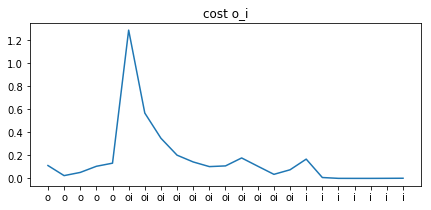

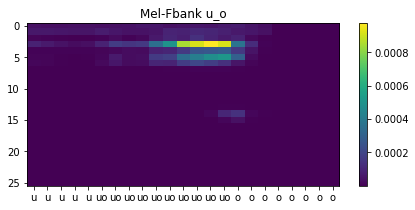

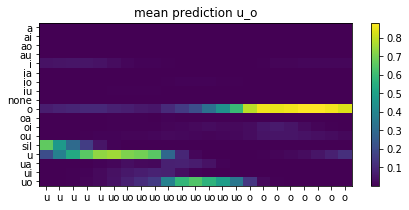

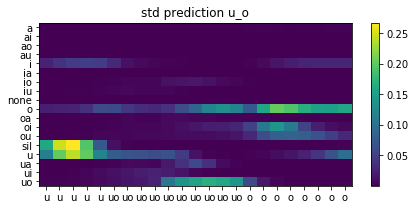

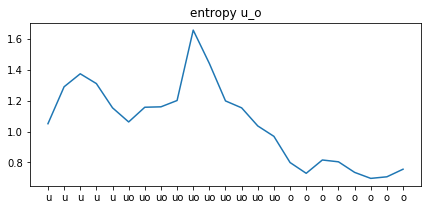

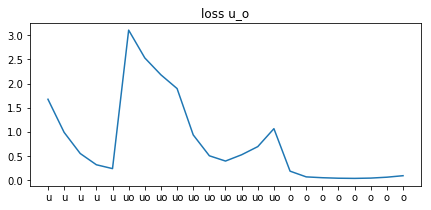

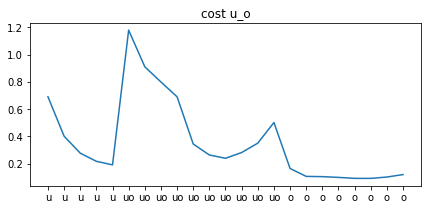

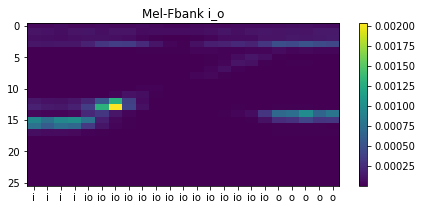

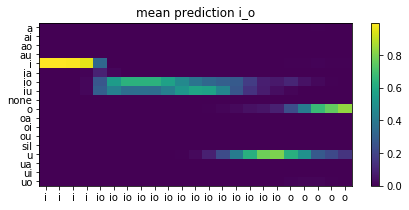

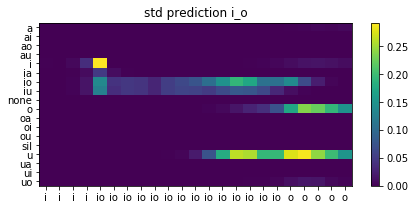

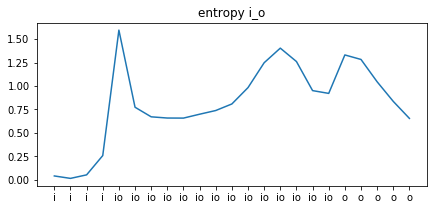

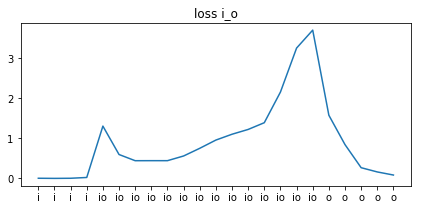

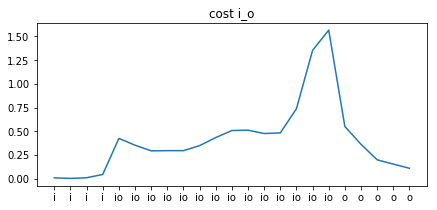

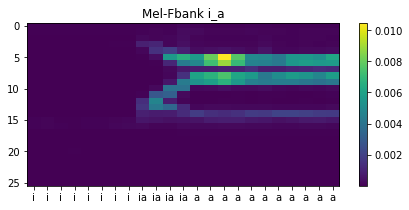

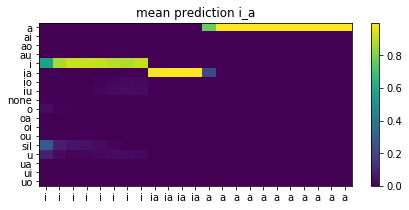

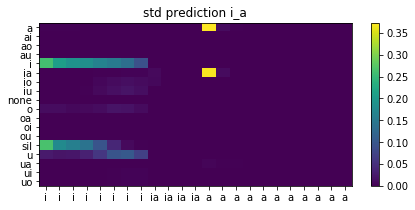

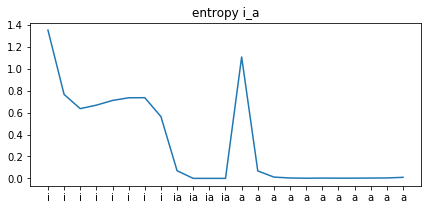

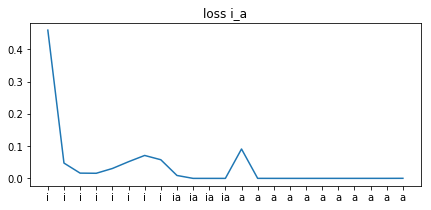

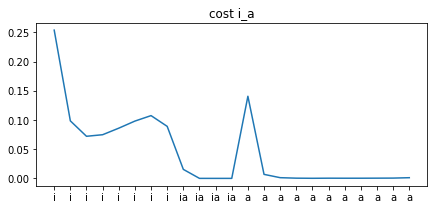

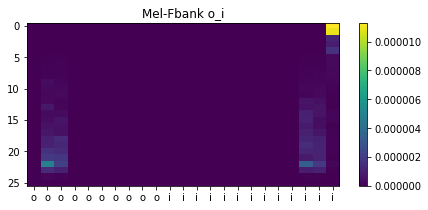

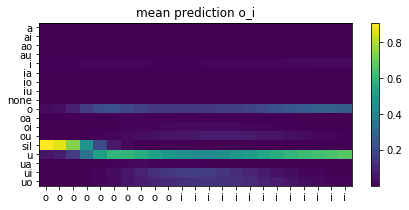

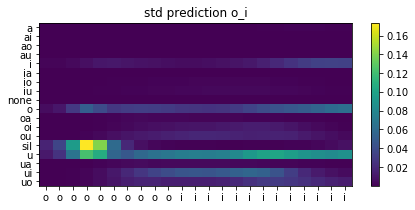

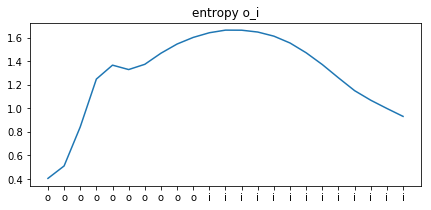

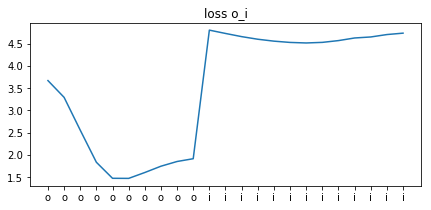

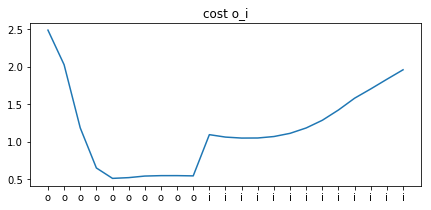

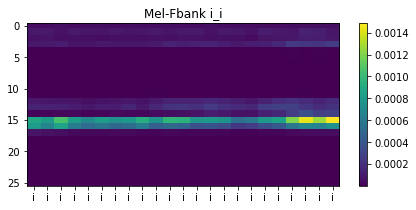

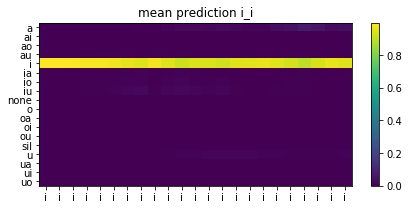

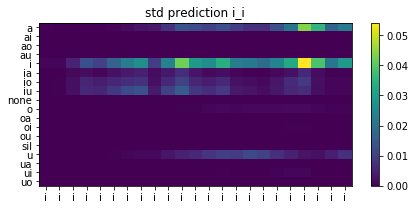

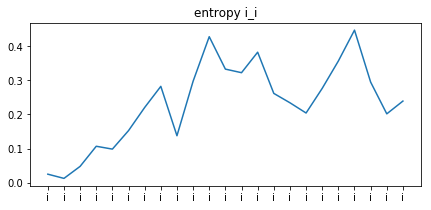

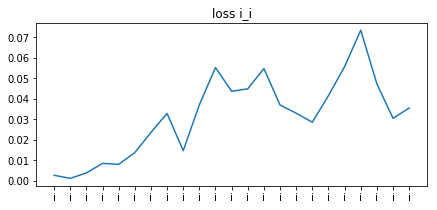

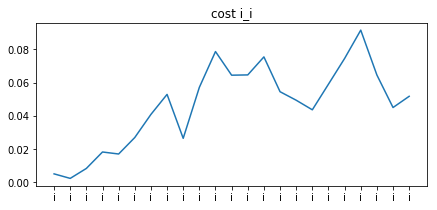

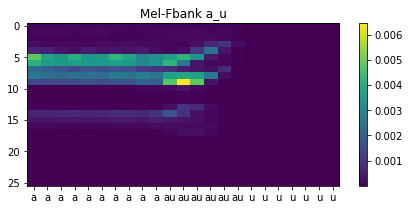

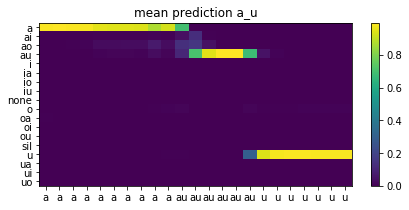

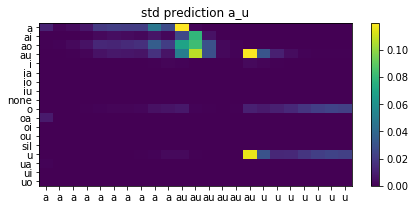

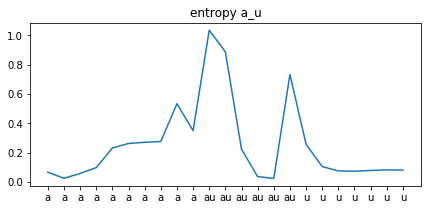

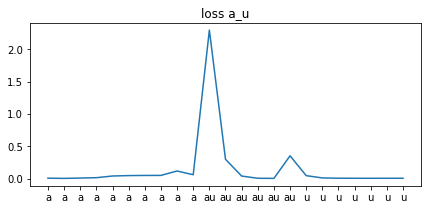

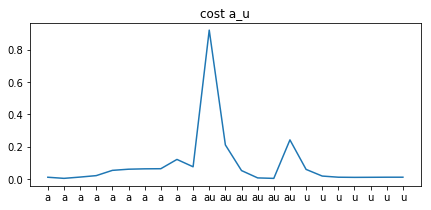

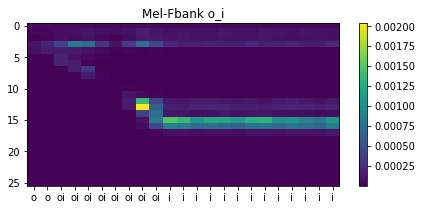

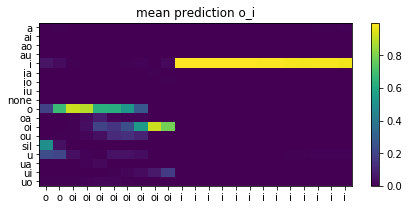

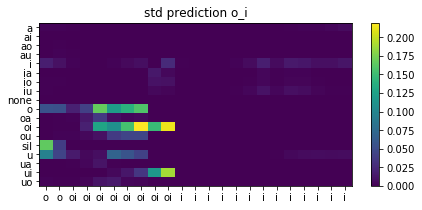

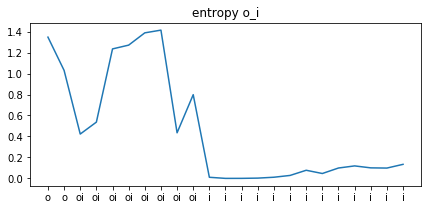

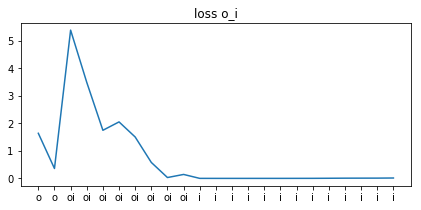

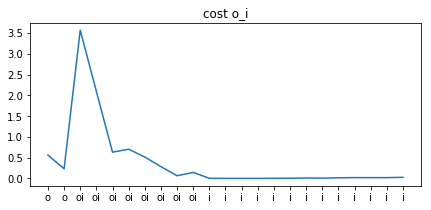

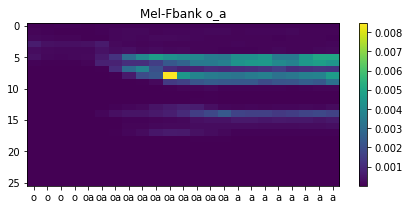

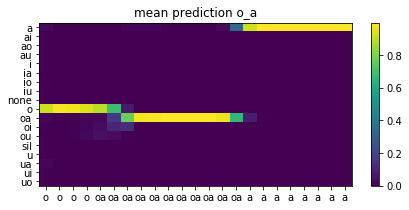

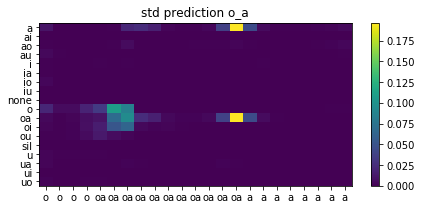

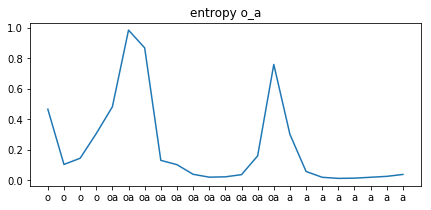

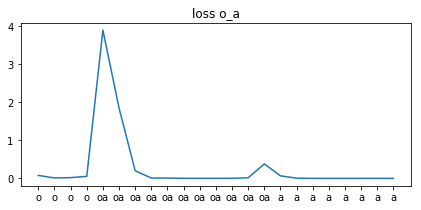

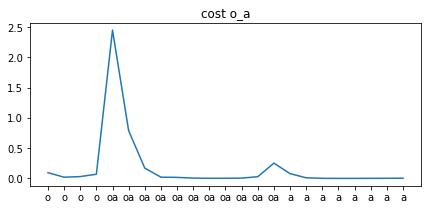

In [143]:
import warnings
warnings.filterwarnings('ignore')
for _ in range(20):
    idx = np.random.randint(0, len(df))
    predict_show(df['y'][idx], processed_audio[idx], labels_int[idx], net, le)

In [144]:
wanted_words = ['bed', 'bird', 'cat', 'dog']
data_iter = SpeechCommandsDataCollector(preproc,
                                        data_dir=data_dir,
                                        wanted_words=wanted_words,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

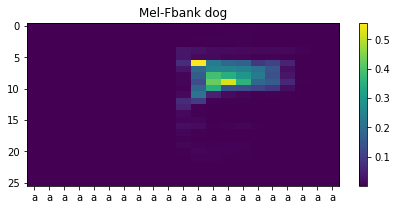

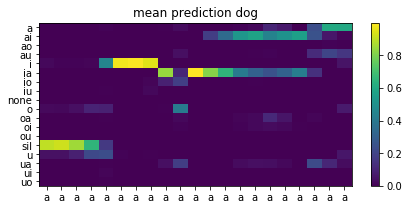

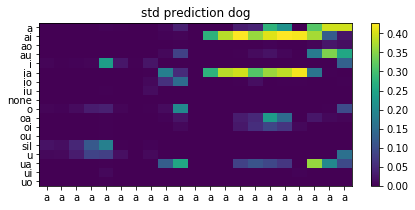

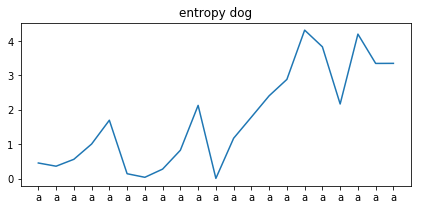

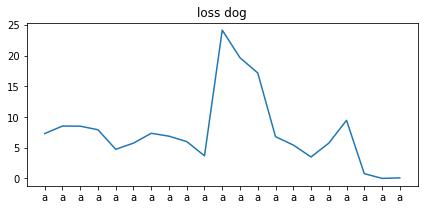

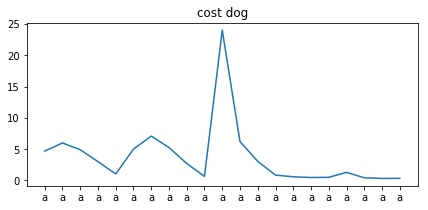

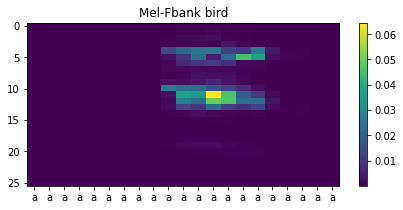

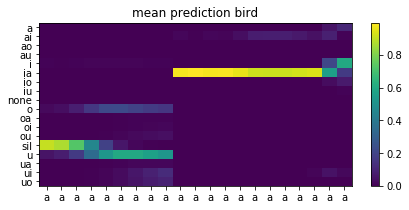

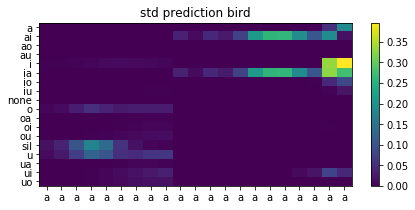

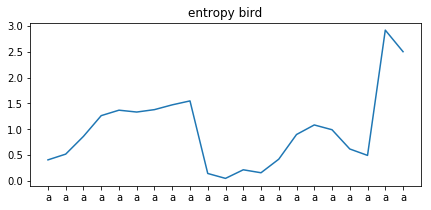

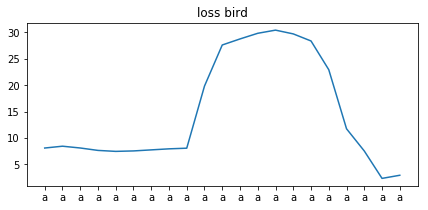

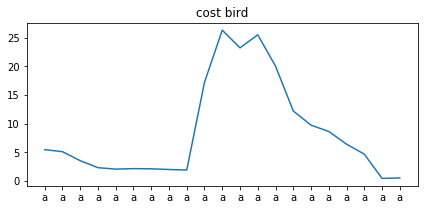

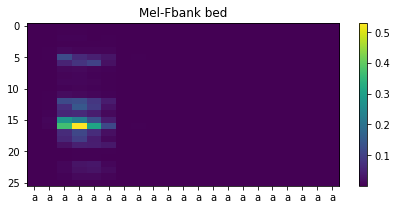

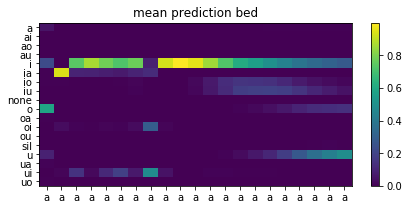

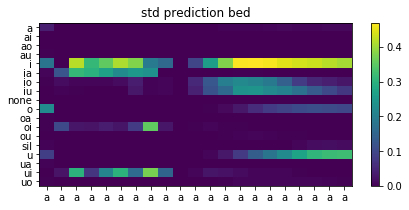

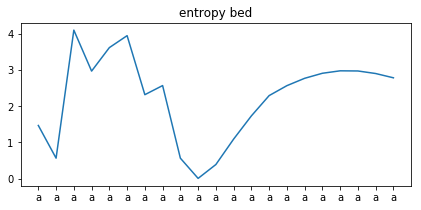

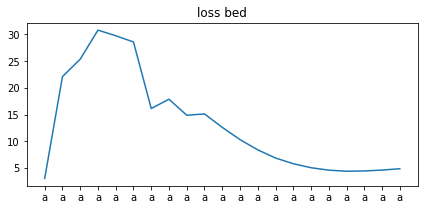

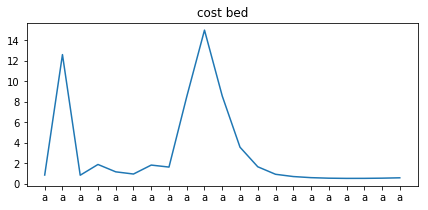

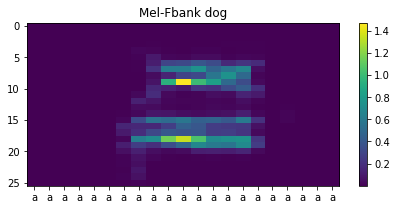

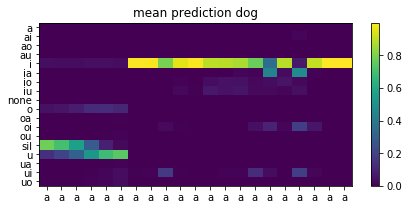

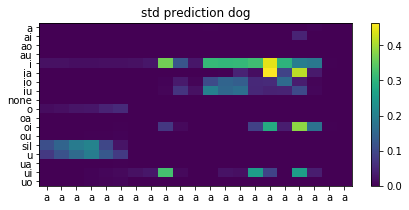

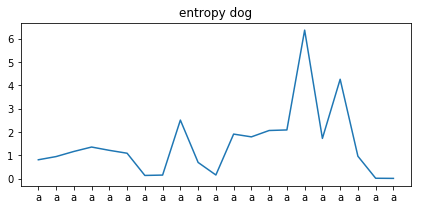

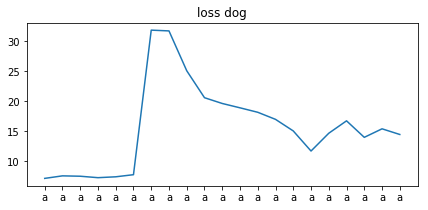

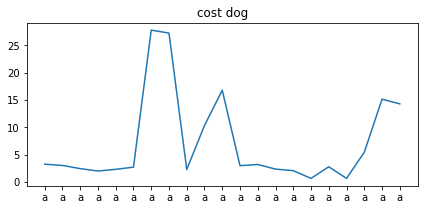

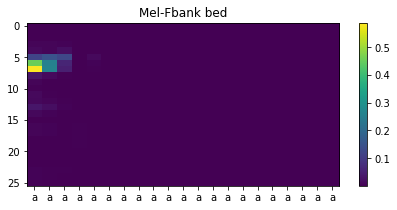

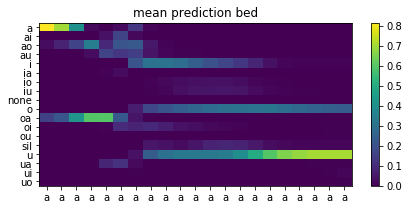

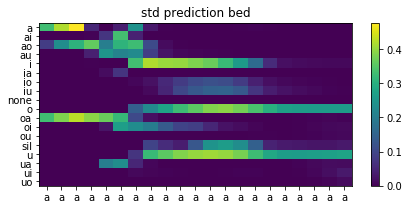

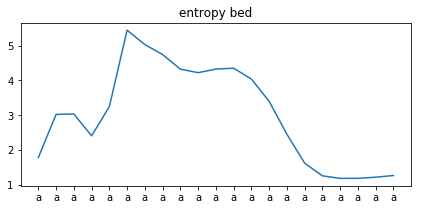

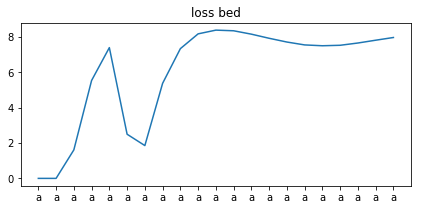

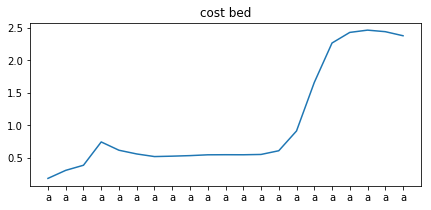

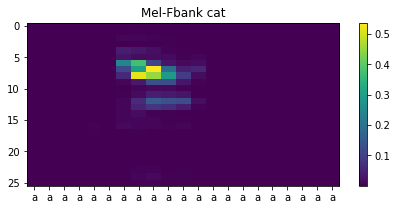

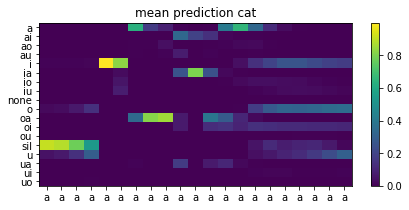

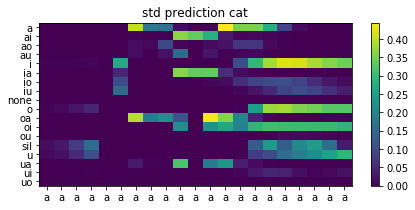

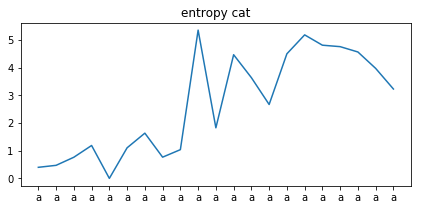

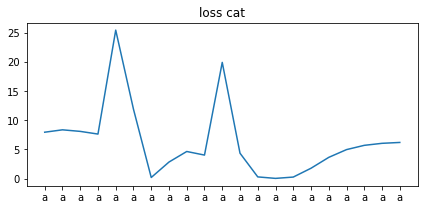

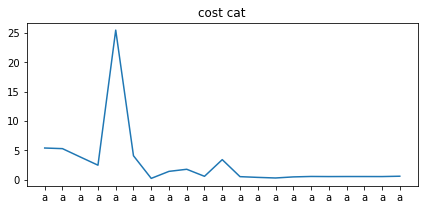

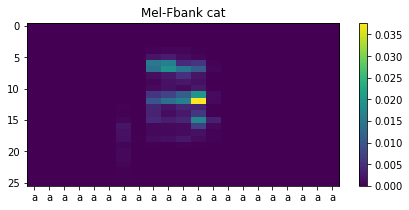

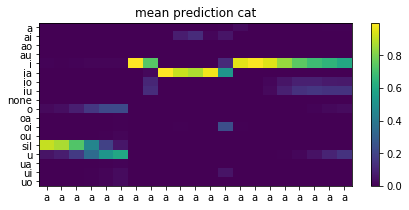

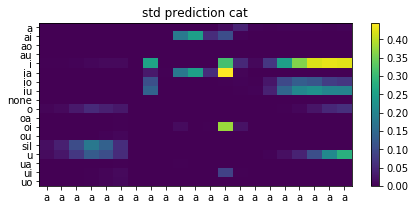

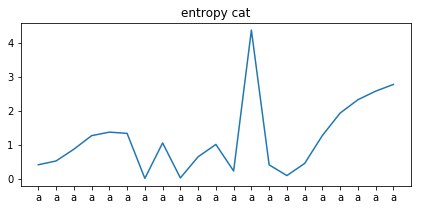

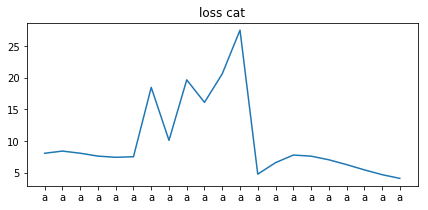

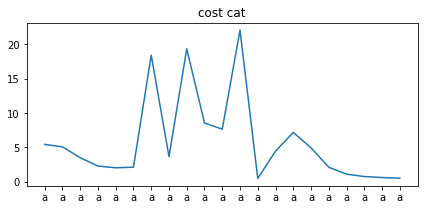

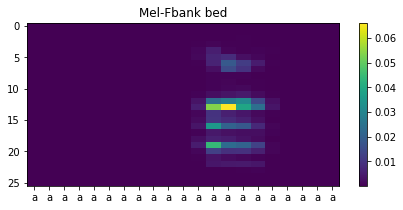

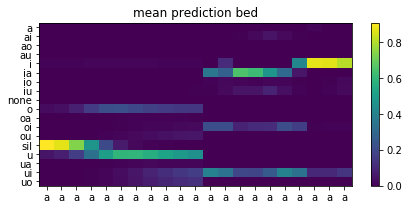

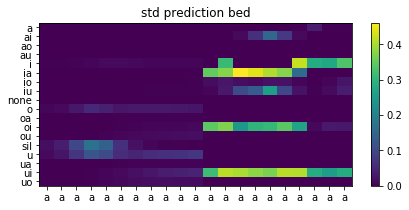

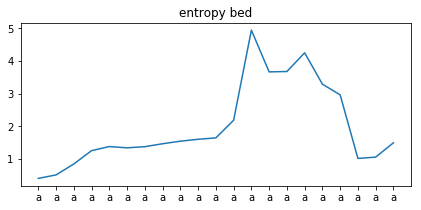

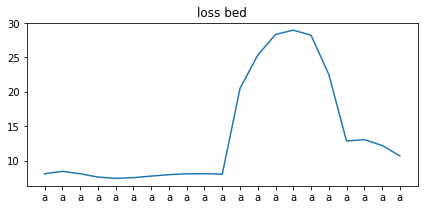

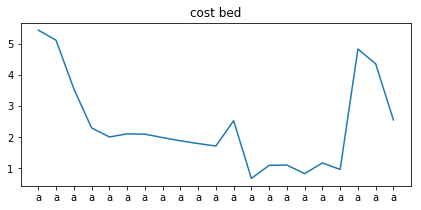

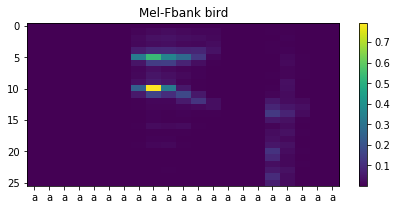

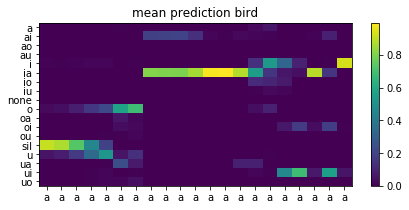

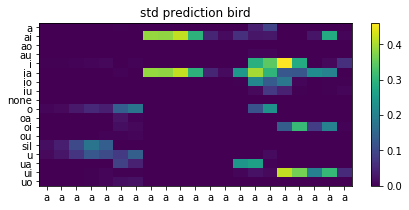

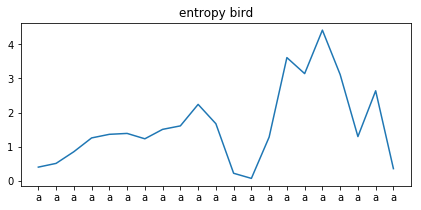

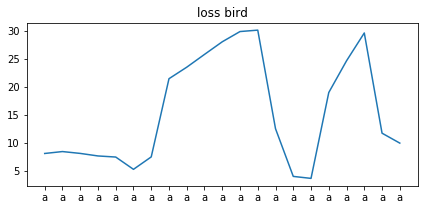

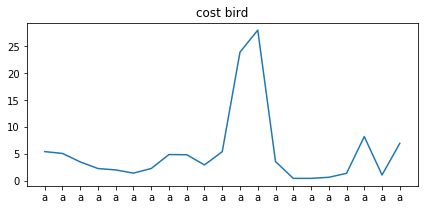

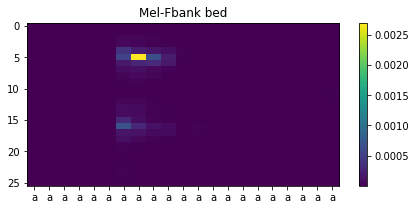

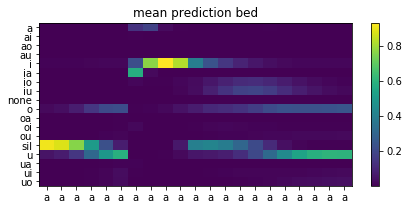

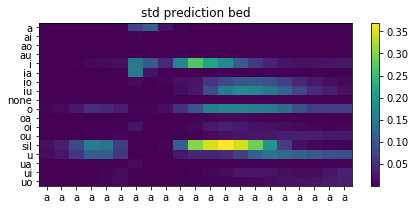

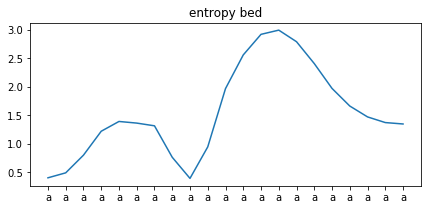

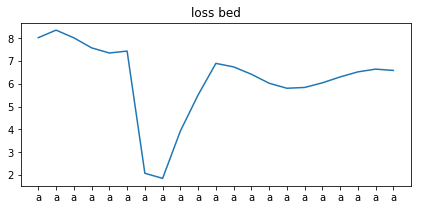

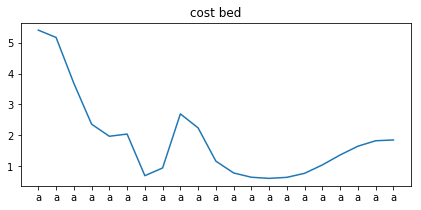

In [145]:
d = data_iter.get_data(10, 0, 'testing')
data_words = d['x'][:, 2:, :]
labels_words = d['y']
seq_lengths = d['seq_len']

for idx in range(len(labels)):
    labels_int = np.array(le.transform(['a']*(processed_audio[idx].shape[0]-2)))
    predict_show(wanted_words[int(labels_words[idx])-2], data_words[idx], labels_int, net, le)
